In [1]:
% matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import curve_fit
from PIL import Image

j = complex(0,1)

# Properties of the Experiment

If we use numpy's discrete fft transform function, the frequencies measured will be sampled from $0$ to $X$ with step size $\Delta k=1/X$:

$$\vec{k}=\left[0, 1/X, 2/X, ...,  1\right] $$

In fourier optics, the projection of the relationship between the $k$'s of the fourier transform and <i> the actual displacement on the screen </i> is given by

$$ x = \frac{\lambda f}{2 \pi}k \implies \Delta x = \frac{\lambda f}{2 \pi}\Delta k$$

where $\lambda$ is the wavelength of the light and $f$ is the focal length of the lens. It follows that the spacing on the screen is given by

$$\Delta x =  \frac{\lambda f}{2 \pi X}$$

In other words, the points of the image $\Delta x_{im}$ on the back focal plane are related to the points from the object $\Delta x_{ob}$ on the front focal plane by

$$\Delta x_{im} = \frac{\lambda f}{2 \pi X} \Delta x_{ob} \equiv \alpha \Delta x_{ob}$$

In [2]:
lam = 655e-9
f = 200e-3

Pix_Size = 6.45e-6
X_Pixels = 1360
Y_Pixels = 1024

In [3]:
Pix_Size

6.45e-06

In [4]:
def get_image_dimensions(image):
    y_width, x_width = image.shape
    x_arr = np.linspace(1, x_width, x_width) * (X_Pixels/x_width)*Pix_Size
    y_arr = np.linspace(1, y_width, y_width) * (Y_Pixels/y_width)*Pix_Size
    
    return x_arr, y_arr, image

'''
def get_simulation_dimensions(f_trans):
    ky_width, kx_width = f_trans.shape
    
    del_kx = kx_width/(X_Pixels*Pix_Size)
    del_ky = ky_width/(Y_Pixels*Pix_Size)
    kx_arr = np.linspace(1, kx_width, kx_width) *((lam*f)/(2*np.pi))*del_kx
    ky_arr = np.linspace(1, ky_width, ky_width) *((lam*f)/(2*np.pi))*del_ky
    
    return kx_arr, ky_arr, f_trans
'''

'\ndef get_simulation_dimensions(f_trans):\n    ky_width, kx_width = f_trans.shape\n    \n    del_kx = kx_width/(X_Pixels*Pix_Size)\n    del_ky = ky_width/(Y_Pixels*Pix_Size)\n    kx_arr = np.linspace(1, kx_width, kx_width) *((lam*f)/(2*np.pi))*del_kx\n    ky_arr = np.linspace(1, ky_width, ky_width) *((lam*f)/(2*np.pi))*del_ky\n    \n    return kx_arr, ky_arr, f_trans\n'

Go to 0.5 bc don't need negative values -0.5 to 0.

In [5]:
def get_simulation_dimensions(f_trans):
    ky_width, kx_width = f_trans.shape
    
    del_x = (X_Pixels*Pix_Size)/kx_width
    del_y = (Y_Pixels*Pix_Size)/ky_width
    
    kx_arr = np.linspace(0, 1, kx_width)*(lam*f/del_x)
    ky_arr = np.linspace(0, 1, ky_width)*(lam*f/del_y)
    
    return kx_arr, ky_arr, f_trans

In [6]:
def sinc(x, a, R, b):
    return a*np.abs(np.sinc(R*(x-b)))

def square(x, A, a, b):
    return A*(np.heaviside(x-a,1)-np.heaviside(x-b,1))

In [7]:
def remove_baseline(im, n=20):
    baseline = im[0][0:n].mean()
    return im-baseline

# Open Image

In [8]:
im = Image.open("Square_Aperture/Image_1_#001.bmp").convert('L')
p = np.array(im)
p = p/p.sum()
p = remove_baseline(p)

# Plot Image

<IPython.core.display.Javascript object>


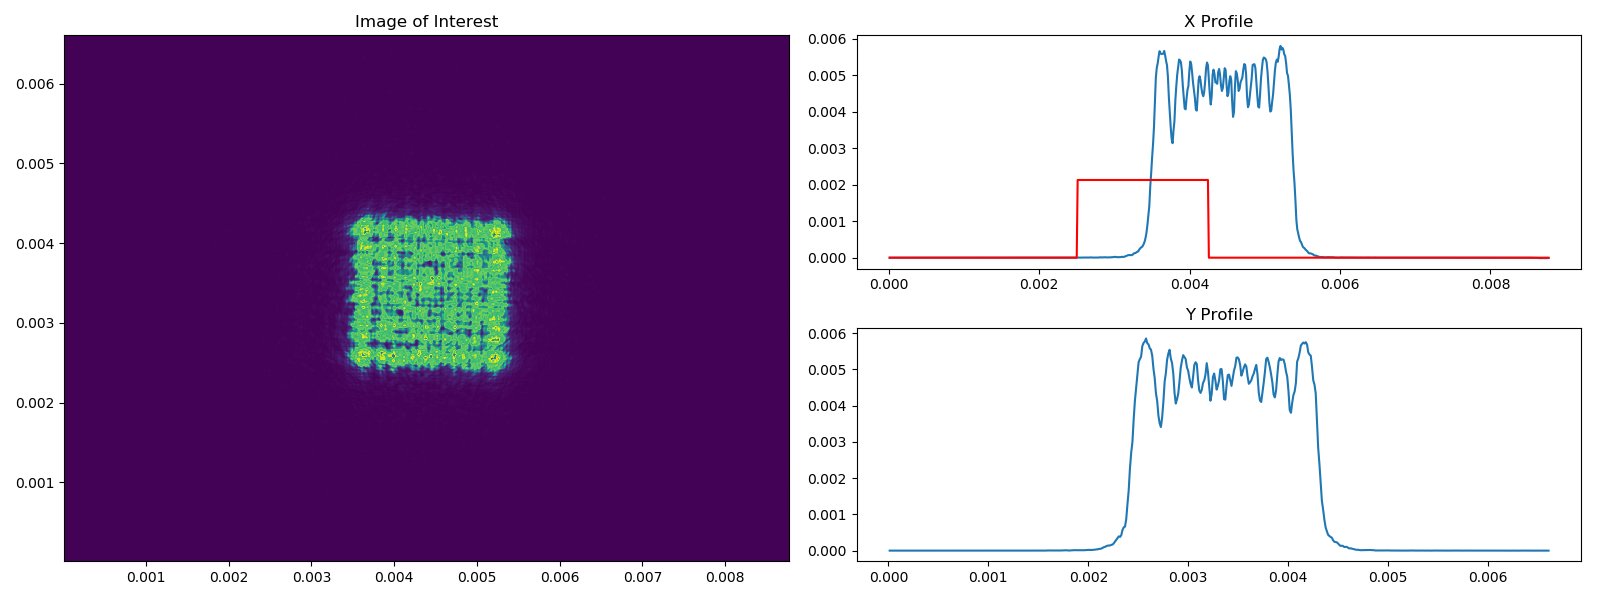

C:\Users\lukep\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [9]:
fig = plt.figure(figsize = (16,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

x, y, z = get_image_dimensions(p)
ax1.pcolor(x, y, z)
ax1.set_title('Image of Interest')

hx, hy = z.sum(axis=0), z.sum(axis=1)
ax2.plot(x, hx)
ax2.set_title('X Profile')
ax3.plot(y, hy)
ax3.set_title('Y Profile')

(A, a, b), pcov = curve_fit(square, x, hx, p0=(0.005, 0.0025, 0.00425))
ax2.plot(x, square(x, A, a, b), color='r')

fig.tight_layout()
plt.show()

# Simulate Fourier Transform on Image

In [10]:
g=np.abs(np.fft.fft2(p))
g = g/g.sum()
G = np.fft.fftshift( g )

# Open Actual Fourier Transform on Image

In [11]:
im2 = Image.open("Square_Aperture/Fourier_1_#001.bmp").convert('L')
p2 = np.array(im2)
p2 = p2/p2.sum()
p2 = remove_baseline(p2)

# Plot Observed

<IPython.core.display.Javascript object>


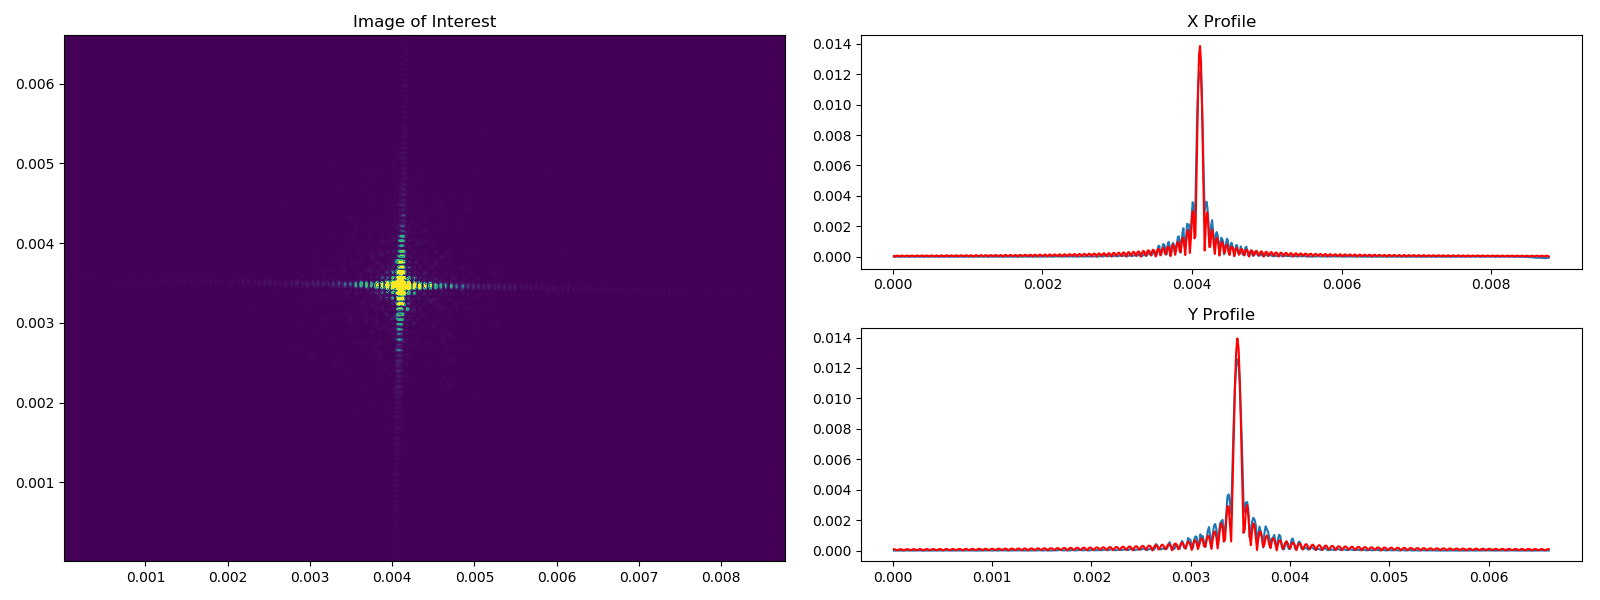

In [12]:
fig = plt.figure(figsize = (16,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

x, y, z = get_image_dimensions(p2)
ax1.pcolor(x, y, z)
ax1.set_title('Image of Interest')

hx, hy = z.sum(axis=0), z.sum(axis=1)
ax2.plot(x, hx)
ax2.set_title('X Profile')
ax3.plot(y, hy)
ax3.set_title('Y Profile')

(a, R, b), pcov = curve_fit(sinc, x, hx, p0=(np.amax(hx), 1/0.00007, x[np.argmax(hx)]))
ax2.plot(x, sinc(x, a, R, b), color='r')

(a, R, b), pcov = curve_fit(sinc, y, hy, p0=(np.amax(hy), 1/0.00007, y[np.argmax(hy)]))
ax3.plot(y, sinc(y, a, R, b), color='r')

fig.tight_layout()
plt.show()

In [13]:
R

15185.389216295784

# Plot Simulated

<IPython.core.display.Javascript object>


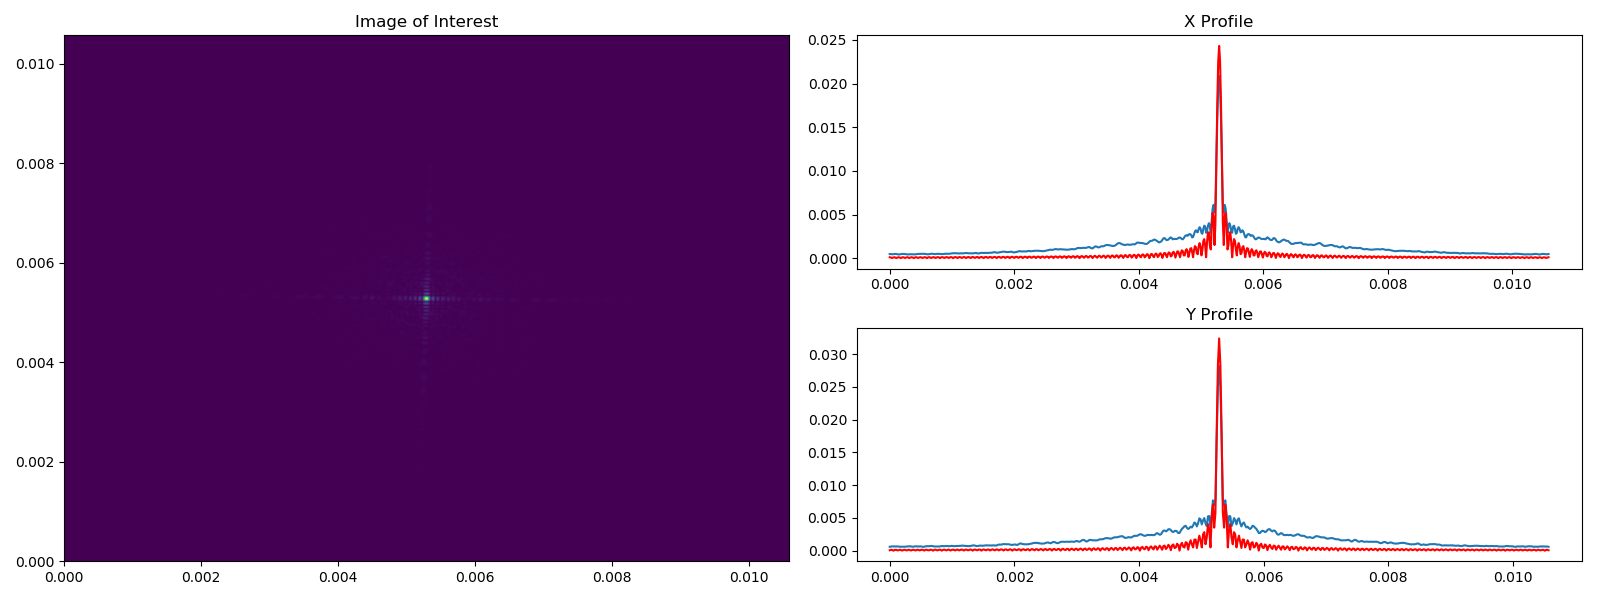

In [14]:
fig = plt.figure(figsize = (16,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

x, y, z = get_simulation_dimensions(np.abs(G))
ax1.pcolor(x, y, z)
ax1.set_title('Image of Interest')

hx, hy = z.sum(axis=0), z.sum(axis=1)
ax2.plot(x, hx)
ax2.set_title('X Profile')
ax3.plot(y, hy)
ax3.set_title('Y Profile')

(a, R, b), pcov = curve_fit(sinc, x, hx, p0=(np.amax(hx), 1/0.00007, x[np.argmax(hx)]))
ax2.plot(x, sinc(x, a, R, b), color='r')

(a, R, b), pcov = curve_fit(sinc, y, hy, p0=(np.amax(hy), 1/0.00007, y[np.argmax(hy)]))
ax3.plot(y, sinc(y, a, R, b), color='r')

fig.tight_layout()
plt.show()

In [15]:
R

14158.35031066579